In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['axes.titlecolor'] = 'w'

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.figsize" : (10,10),
          "axes.titlecolor" : 'w'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
image_size = (128,128)
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 10586 files belonging to 9 classes.
Using 8469 files for training.
Found 10586 files belonging to 9 classes.
Using 2117 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']


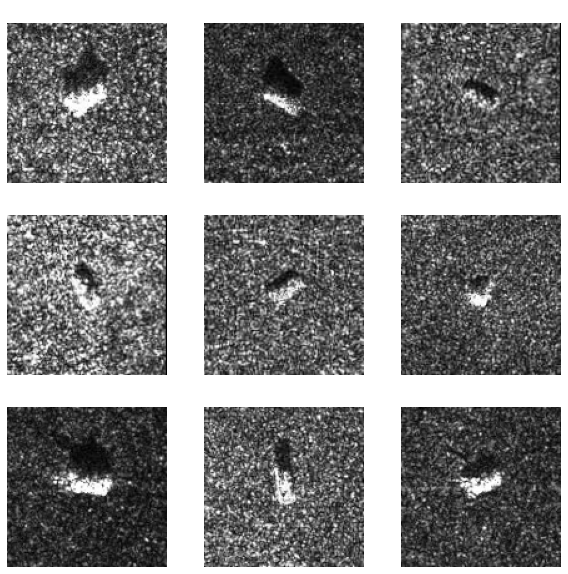

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])], )
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 1)
(32, 9)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes=9

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [11]:
model1 = keras.Sequential()

model1.add(layers.InputLayer(input_shape=(128, 128, 1)))

model1.add(layers.Flatten())

model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(100, activation='relu'))

model1.add(layers.Dense(num_classes, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1638500   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 1,659,609
Trainable params: 1,659,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [13]:
history1 = model1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 6s 13ms/step - loss: 54.5140 - tp: 3765.0000 - fp: 4666.0000 - tn: 63086.0000 - fn: 4704.0000 - accuracy: 0.8771 - precision: 0.4466 - recall: 0.4446 - auc: 0.7174 - prc: 0.3318 - val_loss: 4.0348 - val_tp: 1419.0000 - val_fp: 681.0000 - val_tn: 16255.0000 - val_fn: 698.0000 - val_accuracy: 0.9276 - val_precision: 0.6757 - val_recall: 0.6703 - val_auc: 0.8640 - val_prc: 0.6226
Epoch 2/10
265/265 [==============================] - 3s 10ms/step - loss: 3.5365 - tp: 6399.0000 - fp: 2040.0000 - tn: 65712.0000 - fn: 2070.0000 - accuracy: 0.9461 - precision: 0.7583 - recall: 0.7556 - auc: 0.9021 - prc: 0.7235 - val_loss: 1.5877 - val_tp: 1727.0000 - val_fp: 387.0000 - val_tn: 16549.0000 - val_fn: 390.0000 - val_accuracy: 0.9592 - val_precision: 0.8169 - val_recall: 0.8158 - val_auc: 0.9363 - val_prc: 0.8141
Epoch 3/10
265/265 [==============================] - 3s 10ms/step - loss: 1.7030 - tp: 7199.0000 - fp: 1244.0000 - tn: 66508.0000 - 

In [14]:
def plot_metrics(history):
  with plt.rc_context(params):    
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])

      plt.legend();

In [15]:
def plot_cm(model):
    with plt.rc_context(params):
        y_true = []
        y_pred = []
        for x,y in val_ds:
            y= tf.argmax(y,axis=1)
            y_true.append(y)
            y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)

        cm = confusion_matrix(y_true, y_pred)
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(1,1,1)
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
            cbar = False);
        ax1.set_ylabel('True Values',fontsize=14)
        ax1.set_xlabel('Predicted Values',fontsize=14)
        plt.show()

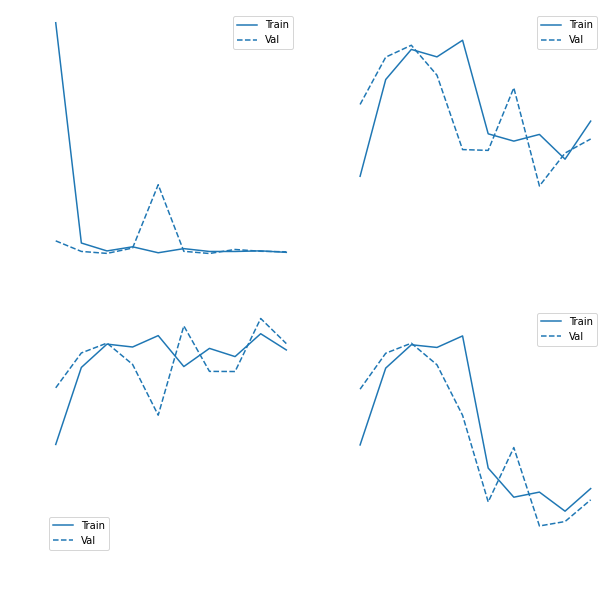

In [16]:
plot_metrics(history1)

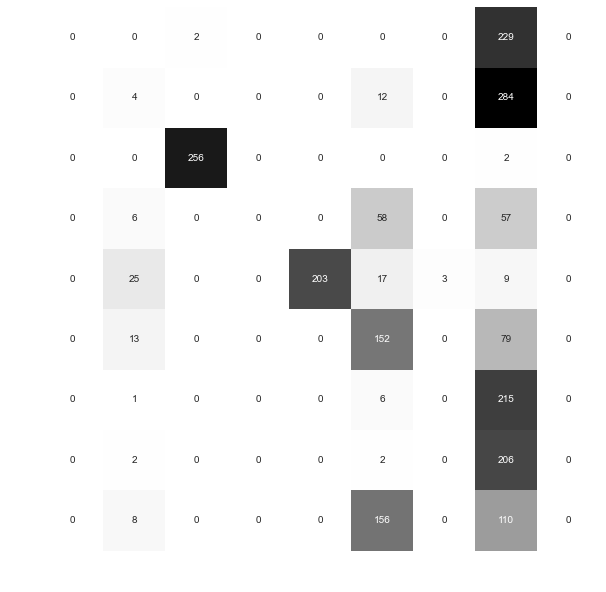

In [17]:
plot_cm(model1)

In [18]:

model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(128,128,1)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

In [19]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)


In [20]:
history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 8s 19ms/step - loss: 0.9307 - tp: 4854.0000 - fp: 514.0000 - tn: 84174.0000 - fn: 5732.0000 - accuracy: 0.9344 - precision: 0.9042 - recall: 0.4585 - auc: 0.9276 - prc: 0.7336 - val_loss: 0.1686 - val_tp: 2005.0000 - val_fp: 72.0000 - val_tn: 16864.0000 - val_fn: 112.0000 - val_accuracy: 0.9903 - val_precision: 0.9653 - val_recall: 0.9471 - val_auc: 0.9986 - val_prc: 0.9904
Epoch 2/10
265/265 [==============================] - 4s 16ms/step - loss: 0.1126 - tp: 8126.0000 - fp: 228.0000 - tn: 67524.0000 - fn: 343.0000 - accuracy: 0.9925 - precision: 0.9727 - recall: 0.9595 - auc: 0.9990 - prc: 0.9943 - val_loss: 0.0948 - val_tp: 2049.0000 - val_fp: 50.0000 - val_tn: 16886.0000 - val_fn: 68.0000 - val_accuracy: 0.9938 - val_precision: 0.9762 - val_recall: 0.9679 - val_auc: 0.9992 - val_prc: 0.9957
Epoch 3/10
265/265 [==============================] - 4s 16ms/step - loss: 0.0694 - tp: 8265.0000 - fp: 155.0000 - tn: 67597.0000 - fn: 204.

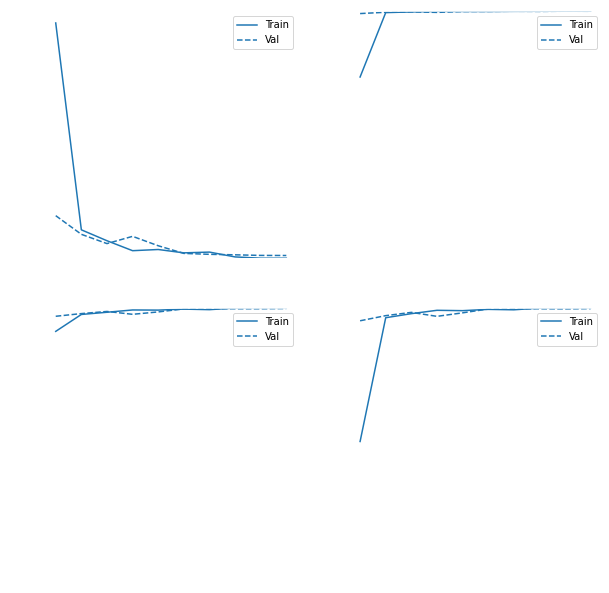

In [21]:
with plt.rc_context(params):
    plot_metrics(history2)

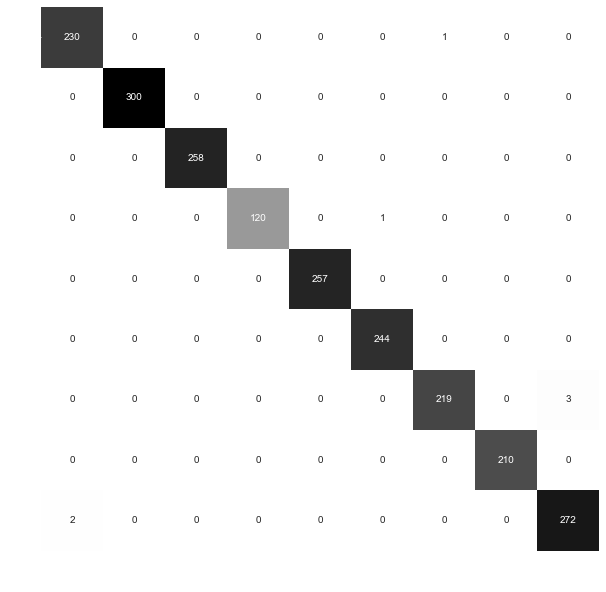

In [22]:
plot_cm(model2)

In [23]:
CNN = Sequential()

CNN.add(layers.InputLayer(input_shape=(128, 128, 1)))


CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))

CNN.add(MaxPooling2D())


CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))

CNN.add(MaxPooling2D())


CNN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

CNN.add(GlobalAveragePooling2D())


CNN.add(Dense(20, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))

CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
global_average_pooling2d (Gl (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)               

In [24]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [25]:
cnn_hist = CNN.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 6s 16ms/step - loss: 2.0255 - tp: 2689.0000 - fp: 181.0000 - tn: 84507.0000 - fn: 7897.0000 - accuracy: 0.9152 - precision: 0.9369 - recall: 0.2540 - auc: 0.7919 - prc: 0.4959 - val_loss: 1.5279 - val_tp: 288.0000 - val_fp: 2.0000 - val_tn: 16934.0000 - val_fn: 1829.0000 - val_accuracy: 0.9039 - val_precision: 0.9931 - val_recall: 0.1360 - val_auc: 0.8378 - val_prc: 0.4774
Epoch 2/10
265/265 [==============================] - 3s 13ms/step - loss: 1.2103 - tp: 2628.0000 - fp: 455.0000 - tn: 67297.0000 - fn: 5841.0000 - accuracy: 0.9174 - precision: 0.8524 - recall: 0.3103 - auc: 0.9066 - prc: 0.6287 - val_loss: 0.8466 - val_tp: 924.0000 - val_fp: 77.0000 - val_tn: 16859.0000 - val_fn: 1193.0000 - val_accuracy: 0.9333 - val_precision: 0.9231 - val_recall: 0.4365 - val_auc: 0.9586 - val_prc: 0.7793
Epoch 3/10
265/265 [==============================] - 3s 13ms/step - loss: 0.8584 - tp: 3906.0000 - fp: 673.0000 - tn: 67079.0000 - fn: 456

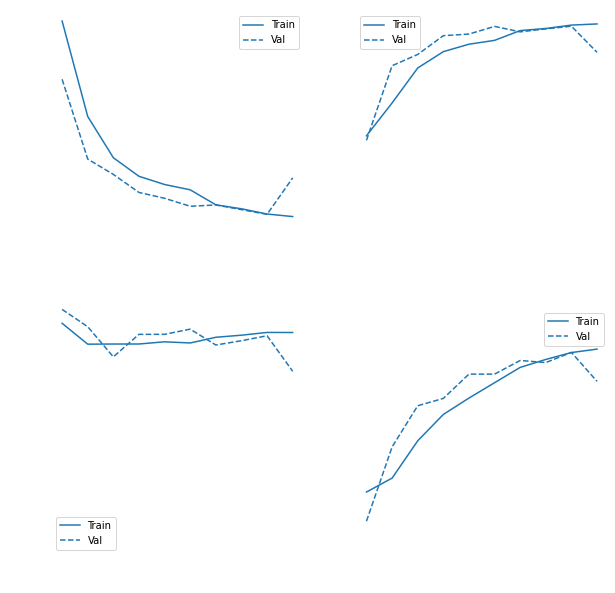

In [26]:
plot_metrics(cnn_hist)

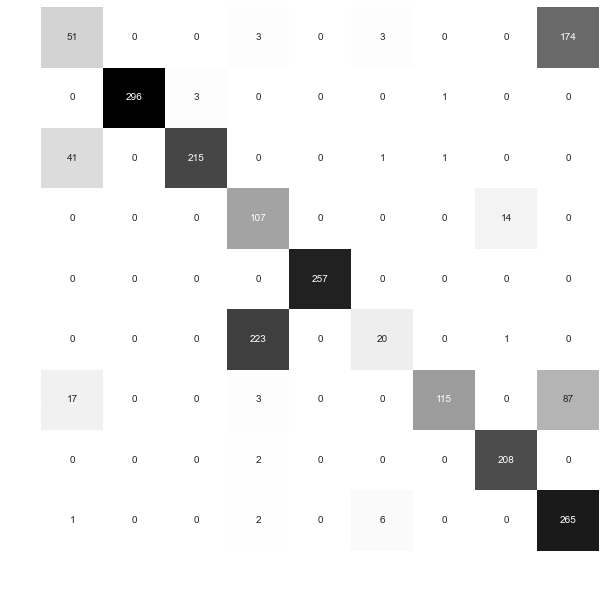

In [27]:
plot_cm(CNN)

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(128,128),
  layers.Rescaling(1./255)])

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ]
)

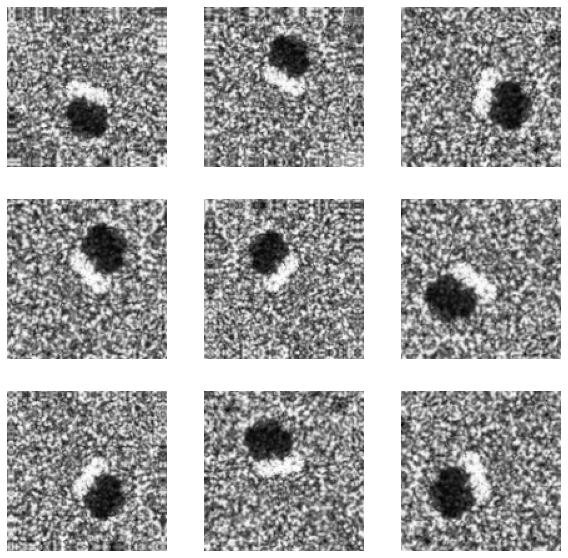

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [31]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


xception = make_model(input_shape=image_size + (1,), num_classes=9)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128, 128, 1)  0           sequential_3[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         sequential_4[0][0]               
______________________________________________________________________________________________

In [32]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_recall', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)
xception_hist = xception.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 29s 93ms/step - loss: 1.1082 - tp: 5497.0000 - fp: 1956.0000 - tn: 82732.0000 - fn: 5089.0000 - accuracy: 0.9261 - precision: 0.7376 - recall: 0.5193 - auc: 0.9342 - prc: 0.7180 - val_loss: 4.8743 - val_tp: 274.0000 - val_fp: 1843.0000 - val_tn: 15093.0000 - val_fn: 1843.0000 - val_accuracy: 0.8065 - val_precision: 0.1294 - val_recall: 0.1294 - val_auc: 0.5203 - val_prc: 0.1262
Epoch 2/100
265/265 [==============================] - 23s 87ms/step - loss: 0.5365 - tp: 6394.0000 - fp: 1158.0000 - tn: 66594.0000 - fn: 2075.0000 - accuracy: 0.9576 - precision: 0.8467 - recall: 0.7550 - auc: 0.9806 - prc: 0.8949 - val_loss: 8.7065 - val_tp: 288.0000 - val_fp: 1730.0000 - val_tn: 15206.0000 - val_fn: 1829.0000 - val_accuracy: 0.8132 - val_precision: 0.1427 - val_recall: 0.1360 - val_auc: 0.5480 - val_prc: 0.1477
Epoch 3/100
265/265 [==============================] - 22s 85ms/step - loss: 0.3614 - tp: 7150.0000 - fp: 868.0000 - tn: 66884.0

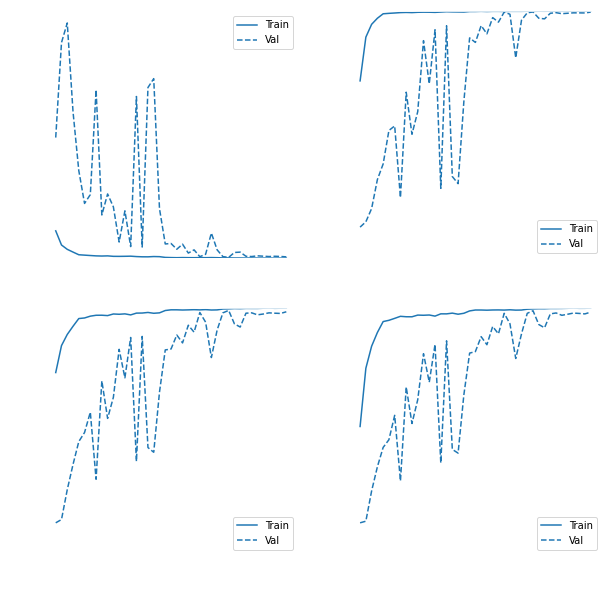

In [33]:
plot_metrics(xception_hist)

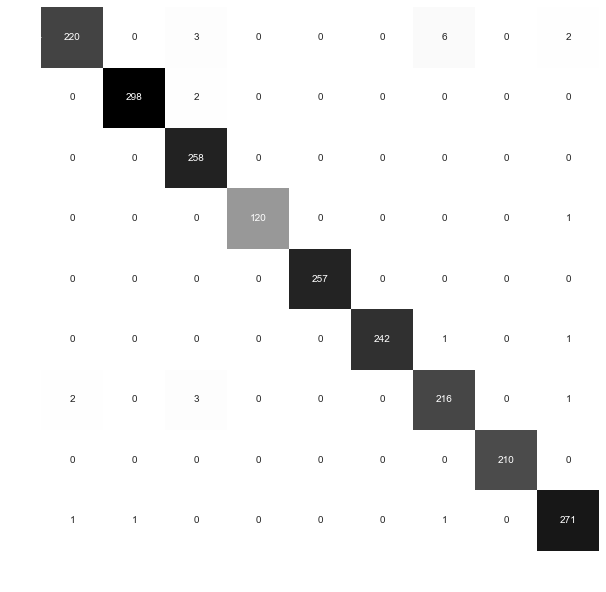

In [34]:
plot_cm(xception)